# AE

## Import and Config

In [1]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from collections import OrderedDict
from easydict import EasyDict
import argparse
import os
import matplotlib.pyplot as plt
import pandas as pd
from torchsummary import summary
from _main_base import *


#---
# config
#---
cfg = EasyDict()

# class
cfg.CLASS_LABEL = range(10) # list, dict('label' : '[B, G, R]')
cfg.CLASS_NUM = len(cfg.CLASS_LABEL)

cfg.ANORMALY_DETECT_TARGET_CLASS = 7

# model
cfg.INPUT_HEIGHT = 28
cfg.INPUT_WIDTH = 28
cfg.INPUT_CHANNEL = 1
cfg.INPUT_MODE = None # None, RGB, GRAY, EDGE, CLASS_LABEL

cfg.OUTPUT_HEIGHT = 28
cfg.OUTPUT_WIDTH = 28
cfg.OUTPUT_CHANNEL = 1
cfg.OUTPUT_MODE = None  # RGB, GRAY, EDGE, CLASS_LABEL

cfg.OUTPUT_CMAP = 'gray' # matplotlib cmap  (default : None)

# AE config
cfg.AE_DIM = 2 # AE encodes feature to this
cfg.AE_STACK_NUM = 3 # AE stack number, e.g. Input > encoder 1 > encoder 2 > ... > encoder this
cfg.AE_DIM_EXPAND_BASE = 8 # AE : layer output = AE_DIM * (AE_DIM_EXPAND_BASE ** N (encoder or decoder stage))

cfg.CHANNEL_AXIS = 1 # 1 ... [mb, c, h, w], 3 ... [mb, h, w, c]

cfg.GPU = False
cfg.DEVICE = torch.device('cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu')

# train
cfg.TRAIN = EasyDict()

cfg.PREFIX = 'AE_anormalyDetect_mnist'
cfg.TRAIN.MODEL_SAVE_PATH = 'models/' + cfg.PREFIX + '_{}.pt' # save model to this path
cfg.TRAIN.MODEL_SAVE_INTERVAL = 1_000 # save model in each this
cfg.TRAIN.ITERATION = 5_000 # max training iteration
cfg.TRAIN.MINIBATCH = 512
cfg.TRAIN.OPTIMIZER = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS = {'lr' : 0.01, 'weight_decay' : 1e-5}
cfg.TRAIN.LOSS_FUNCTION = torch.nn.MSELoss()

cfg.TRAIN.DATA_PATH = './data/' # use this dataset path
cfg.TRAIN.DATA_HORIZONTAL_FLIP = False # data augmentation : holizontal flip
cfg.TRAIN.DATA_VERTICAL_FLIP = False # data augmentation : vertical flip
cfg.TRAIN.DATA_ROTATION = False # data augmentation : rotation False, or integer

cfg.TRAIN.DISPLAY_ITERATION_INTERVAL = 1000
cfg.TRAIN.LEARNING_PROCESS_PROGRESS_INTERVAL = 10 # save loss in each this
cfg.TRAIN.LEARNING_PROCESS_RESULT_SHOW = 1000 # integer , False (not show)
cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True # save result image and loss text
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 1_000 # save image and loss text in each this
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.txt'


# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_PATH = cfg.TRAIN.MODEL_SAVE_PATH.format('final') # use this trained path
cfg.TEST.DATA_PATH = './data' # use this dataset path
cfg.TEST.MINIBATCH = 10
cfg.TEST.MAX_SAMPLES = 30
cfg.TEST.ITERATION = 2
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)


# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)

make_dir(cfg.TRAIN.MODEL_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)


## Define Model

In [2]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

class AE(torch.nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        
        _layer_dim = max(cfg.AE_DIM * (cfg.AE_DIM_EXPAND_BASE ** (cfg.AE_STACK_NUM - 1)), cfg.AE_DIM)
        
        # Encoder
        module_encoder = OrderedDict({
            'encoder_flatten' : Flatten(),
            'encoder_1_layer' : torch.nn.Linear(cfg.INPUT_HEIGHT * cfg.INPUT_WIDTH * cfg.INPUT_CHANNEL, _layer_dim),
            'encoder_1_activation' : torch.nn.ReLU()
        })
        
        for i in range(2, cfg.AE_STACK_NUM):
            module_encoder['encoder_{}_layer'.format(i)] = torch.nn.Linear(_layer_dim, _layer_dim // cfg.AE_DIM_EXPAND_BASE)
            module_encoder['encoder_{}_activation'.format(i)] = torch.nn.ReLU()
            _layer_dim //= cfg.AE_DIM_EXPAND_BASE

        module_encoder['encoder_{}_layer'.format(cfg.AE_STACK_NUM)] = torch.nn.Linear(_layer_dim, _layer_dim // cfg.AE_DIM_EXPAND_BASE)
        _layer_dim //= cfg.AE_DIM_EXPAND_BASE
            
        # Decoder
        module_decoder = OrderedDict()
        
        for i in range(cfg.AE_STACK_NUM, 1, -1):
            module_decoder['decoder_{}_layer'.format(i)] = torch.nn.Linear(_layer_dim, _layer_dim * cfg.AE_DIM_EXPAND_BASE)
            module_decoder['decoder_{}_activation'.format(i)] = torch.nn.ReLU()
            _layer_dim *= cfg.AE_DIM_EXPAND_BASE
            
        module_decoder['decoder_1'] = torch.nn.Linear(_layer_dim, cfg.OUTPUT_HEIGHT * cfg.OUTPUT_WIDTH * cfg.OUTPUT_CHANNEL)
        module_decoder['decoder_out_activation'] = torch.nn.Tanh()
        
        self.module_encoder = torch.nn.Sequential(module_encoder)
        self.module_decoder = torch.nn.Sequential(module_decoder)
        
    def forward(self, x):
        x = self.module_encoder(x)
        return self.module_decoder(x)
    
    def forward_encoder(self, x):
        return self.module_encoder(x)

## Utility

In [3]:
def result_show(model, Xs, path=None, save=False, show=False, figsize=(12, 4), cmap=None):
    _Xs = Xs.detach().cpu().numpy()
    _Xs = (_Xs * 127.5 + 127.5).astype(np.uint8)
    
    ys = model(Xs).detach().cpu().numpy()
    ys = (ys * 127.5 + 127.5).astype(np.uint8)
    ys = ys.reshape([-1, cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH])
    
    if cfg.OUTPUT_CHANNEL == 1:
        _Xs = _Xs[:, 0]
        ys = ys[:, 0]
    else:
        _Xs = _Xs.transpose(0, 2, 3, 1)
        ys = ys.transpose(0, 2, 3, 1)

    show_max = min(cfg.TEST.MINIBATCH, len(ys))
        
    plt.figure(figsize=figsize)
    for i in range(show_max):
        # show input
        _X = _Xs[i]
        plt.subplot(2, show_max, i + 1)
        plt.imshow(_X, cmap=cmap)
        plt.axis('off')
        plt.title('Input{}'.format(i + 1))
        
        # show output
        _y = ys[i]
        plt.subplot(2, show_max, i + 1 + show_max)
        plt.imshow(_y, cmap=cmap)
        plt.axis('off')
        plt.title('Output{}'.format(i + 1))

    plt.tight_layout()
    
    if save:
        plt.savefig(path)
        print('result was saved to >> {}'.format(path))

    if show:
        plt.show()
    else:
        plt.close()

## Train

0it [00:00, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                   [-1, 16]           2,064
              ReLU-5                   [-1, 16]               0
            Linear-6                    [-1, 2]              34
            Linear-7                   [-1, 16]              48
              ReLU-8                   [-1, 16]               0
            Linear-9                  [-1, 128]           2,176
             ReLU-10                  [-1, 128]               0
           Linear-11                  [-1, 784]         101,136
             Tanh-12                  [-1, 784]               0
Total params: 205,938
Trainable params: 205,938
Non-trainable params: 0
-------------------------------

100%|█████████▉| 26312704/26421880 [00:43<00:00, 1585412.78it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



0it [00:00, ?it/s]


 56%|█████▌    | 16384/29515 [00:00<00:00, 61498.51it/s]
32768it [00:00, 34994.98it/s]                           
0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



 92%|█████████▏| 4071424/4422102 [00:03<00:00, 1194842.00it/s]
4423680it [00:03, 1341742.65it/s]                             
0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]
8192it [00:00, 12069.19it/s]            

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!
training data :  (6000, 28, 28)
training start
||||||||||10||||||||||20||||||||||30||||||||||40||||||||||50||||||||||60||||||||||70||||||||||80||||||||||90||||||||||100||||||||||110||||||||||120||||||||||130||||||||||140||||||||||150||||||||||160||||||||||170||||||||||180||||||||||190||||||||||200||||||||||210||||||||||220||||||||||230||||||||||240||||||||||250||||||||||260||||||||||270||||||||||280||||||||||290||||||||||300||||||||||310||||||||||320||||||||||330||||||||||340||||||||||350||||||||||360||||||||||370||||||||||380||||||||||390||||||||||400||||||||||410||||||||||420||||||||||430||||||||||440||||||||||450||||||||||460||||||||||470||||||||||480||||||||||490||||||||||500||||||||||510||||||||||520||||||||||530||||||||||540||||||||||550||||||||||560||||||||||570||||||||||580||||||||||590||||||||||600||||||||||610||||||||||620||||||||||630||||||||||640||||||||||650||||||||

26427392it [01:00, 1585412.78it/s]                              

||||||||||10||||||||||20||||||||||30||||||||||40||||||||||50||||||||||60||||||||||70||||||||||80||||||||||90||||||||||100||||||||||110||||||||||120||||||||||130||||||||||140||||||||||150||||||||||160||||||||||170||||||||||180||||||||||190||||||||||200||||||||||210||||||||||220||||||||||230||||||||||240||||||||||250||||||||||260||||||||||270||||||||||280||||||||||290||||||||||300||||||||||310||||||||||320||||||||||330||||||||||340||||||||||350||||||||||360||||||||||370||||||||||380||||||||||390||||||||||400||||||||||410||||||||||420||||||||||430||||||||||440||||||||||450||||||||||460||||||||||470||||||||||480||||||||||490||||||||||500||||||||||510||||||||||520||||||||||530||||||||||540||||||||||550||||||||||560||||||||||570||||||||||580||||||||||590||||||||||600||||||||||610||||||||||620||||||||||630||||||||||640||||||||||650||||||||||660||||||||||670

||||||||||10||||||||||20||||||||||30||||||||||40||||||||||50||||||||||60||||||||||70||||||||||80||||||||||90||||||||||100||||||||||110||||||||||120||||||||||130||||||||||140||||||||||150||||||||||160||||||||||170||||||||||180||||||||||190||||||||||200||||||||||210||||||||||220||||||||||230||||||||||240||||||||||250||||||||||260||||||||||270||||||||||280||||||||||290||||||||||300||||||||||310||||||||||320||||||||||330||||||||||340||||||||||350||||||||||360||||||||||370||||||||||380||||||||||390||||||||||400||||||||||410||||||||||420||||||||||430||||||||||440||||||||||450||||||||||460||||||||||470||||||||||480||||||||||490||||||||||500||||||||||510||||||||||520||||||||||530||||||||||540||||||||||550||||||||||560||||||||||570||||||||||580||||||||||590||||||||||600||||||||||610||||||||||620||||||||||630||||||||||640||||||||||650||||||||||660||||||||||670||||||||||680||

||||||||||10||||||||||20||||||||||30||||||||||40||||||||||50||||||||||60||||||||||70||||||||||80||||||||||90||||||||||100||||||||||110||||||||||120||||||||||130||||||||||140||||||||||150||||||||||160||||||||||170||||||||||180||||||||||190||||||||||200||||||||||210||||||||||220||||||||||230||||||||||240||||||||||250||||||||||260||||||||||270||||||||||280||||||||||290||||||||||300||||||||||310||||||||||320||||||||||330||||||||||340||||||||||350||||||||||360||||||||||370||||||||||380||||||||||390||||||||||400||||||||||410||||||||||420||||||||||430||||||||||440||||||||||450||||||||||460||||||||||470||||||||||480||||||||||490||||||||||500||||||||||510||||||||||520||||||||||530||||||||||540||||||||||550||||||||||560||||||||||570||||||||||580||||||||||590||||||||||600||||||||||610||||||||||620||||||||||630||||||||||640||||||||||650||||||||||660||||||||||670||||||||||680||||||||||690||||

||||||||||10||||||||||20||||||||||30||||||||||40||||||||||50||||||||||60||||||||||70||||||||||80||||||||||90||||||||||100||||||||||110||||||||||120||||||||||130||||||||||140||||||||||150||||||||||160||||||||||170||||||||||180||||||||||190||||||||||200||||||||||210||||||||||220||||||||||230||||||||||240||||||||||250||||||||||260||||||||||270||||||||||280||||||||||290||||||||||300||||||||||310||||||||||320||||||||||330||||||||||340||||||||||350||||||||||360||||||||||370||||||||||380||||||||||390||||||||||400||||||||||410||||||||||420||||||||||430||||||||||440||||||||||450||||||||||460||||||||||470||||||||||480||||||||||490||||||||||500||||||||||510||||||||||520||||||||||530||||||||||540||||||||||550||||||||||560||||||||||570||||||||||580||||||||||590||||||||||600||||||||||610||||||||||620||||||||||630||||||||||640||||||||||650||||||||||660||||||||||670||||||||||680||||||||||690||||||||||700||||||

||||||||||10||||||||||20||||||||||30||||||||||40||||||||||50||||||||||60||||||||||70||||||||||80||||||||||90||||||||||100||||||||||110||||||||||120||||||||||130||||||||||140||||||||||150||||||||||160||||||||||170||||||||||180||||||||||190||||||||||200||||||||||210||||||||||220||||||||||230||||||||||240||||||||||250||||||||||260||||||||||270||||||||||280||||||||||290||||||||||300||||||||||310||||||||||320||||||||||330||||||||||340||||||||||350||||||||||360||||||||||370||||||||||380||||||||||390||||||||||400||||||||||410||||||||||420||||||||||430||||||||||440||||||||||450||||||||||460||||||||||470||||||||||480||||||||||490||||||||||500||||||||||510||||||||||520||||||||||530||||||||||540||||||||||550||||||||||560||||||||||570||||||||||580||||||||||590||||||||||600||||||||||610||||||||||620||||||||||630||||||||||640||||||||||650||||||||||660||||||||||670||||||||||680||||||||||690||||||||||700||||||||||710|||||||||

||||||||||10||||||||||20||||||||||30||||||||||40||||||||||50||||||||||60||||||||||70||||||||||80||||||||||90||||||||||100||||||||||110||||||||||120||||||||||130||||||||||140||||||||||150||||||||||160||||||||||170||||||||||180||||||||||190||||||||||200||||||||||210||||||||||220||||||||||230||||||||||240||||||||||250||||||||||260||||||||||270||||||||||280||||||||||290||||||||||300||||||||||310||||||||||320||||||||||330||||||||||340||||||||||350||||||||||360||||||||||370||||||||||380||||||||||390||||||||||400||||||||||410||||||||||420||||||||||430||||||||||440||||||||||450||||||||||460||||||||||470||||||||||480||||||||||490||||||||||500||||||||||510||||||||||520||||||||||530||||||||||540||||||||||550||||||||||560||||||||||570||||||||||580||||||||||590||||||||||600||||||||||610||||||||||620||||||||||630||||||||||640||||||||||650||||||||||660||||||||||670||||||||||680||||||||||690||||||||||700||||||||||710||||||||||720||||||||||730|

||||||||||10||||||||||20||||||||||30||||||||||40||||||||||50||||||||||60||||||||||70||||||||||80||||||||||90||||||||||100||||||||||110||||||||||120||||||||||130||||||||||140||||||||||150||||||||||160||||||||||170||||||||||180||||||||||190||||||||||200||||||||||210||||||||||220||||||||||230||||||||||240||||||||||250||||||||||260||||||||||270||||||||||280||||||||||290||||||||||300||||||||||310||||||||||320||||||||||330||||||||||340||||||||||350||||||||||360||||||||||370||||||||||380||||||||||390||||||||||400||||||||||410||||||||||420||||||||||430||||||||||440||||||||||450||||||||||460||||||||||470||||||||||480||||||||||490||||||||||500||||||||||510||||||||||520||||||||||530||||||||||540||||||||||550||||||||||560||||||||||570||||||||||580||||||||||590||||||||||600||||||||||610||||||||||620||||||||||630||||||||||640||||||||||650||||||||||660||||||||||670||||||||||680||||||||||690||||||||||700||||||||||710||||||||||720||||||||||730||||||||||740|||

||||||||||10||||||||||20||||||||||30||||||||||40||||||||||50||||||||||60||||||||||70||||||||||80||||||||||90||||||||||100||||||||||110||||||||||120||||||||||130||||||||||140||||||||||150||||||||||160||||||||||170||||||||||180||||||||||190||||||||||200||||||||||210||||||||||220||||||||||230||||||||||240||||||||||250||||||||||260||||||||||270||||||||||280||||||||||290||||||||||300||||||||||310||||||||||320||||||||||330||||||||||340||||||||||350||||||||||360||||||||||370||||||||||380||||||||||390||||||||||400||||||||||410||||||||||420||||||||||430||||||||||440||||||||||450||||||||||460||||||||||470||||||||||480||||||||||490||||||||||500||||||||||510||||||||||520||||||||||530||||||||||540||||||||||550||||||||||560||||||||||570||||||||||580||||||||||590||||||||||600||||||||||610||||||||||620||||||||||630||||||||||640||||||||||650||||||||||660||||||||||670||||||||||680||||||||||690||||||||||700||||||||||710||||||||||720||||||||||730||||||||||740||||||||||750|||||

||||||||||10||||||||||20||||||||||30||||||||||40||||||||||50||||||||||60||||||||||70||||||||||80||||||||||90||||||||||100||||||||||110||||||||||120||||||||||130||||||||||140||||||||||150||||||||||160||||||||||170||||||||||180||||||||||190||||||||||200||||||||||210||||||||||220||||||||||230||||||||||240||||||||||250||||||||||260||||||||||270||||||||||280||||||||||290||||||||||300||||||||||310||||||||||320||||||||||330||||||||||340||||||||||350||||||||||360||||||||||370||||||||||380||||||||||390||||||||||400||||||||||410||||||||||420||||||||||430||||||||||440||||||||||450||||||||||460||||||||||470||||||||||480||||||||||490||||||||||500||||||||||510||||||||||520||||||||||530||||||||||540||||||||||550||||||||||560||||||||||570||||||||||580||||||||||590||||||||||600||||||||||610||||||||||620||||||||||630||||||||||640||||||||||650||||||||||660||||||||||670||||||||||680||||||||||690||||||||||700||||||||||710||||||||||720||||||||||730||||||||||740||||||||||750||||||||||760|||||||

||||||||||10||||||||||20||||||||||30||||||||||40||||||||||50||||||||||60||||||||||70||||||||||80||||||||||90||||||||||100||||||||||110||||||||||120||||||||||130||||||||||140||||||||||150||||||||||160||||||||||170||||||||||180||||||||||190||||||||||200||||||||||210||||||||||220||||||||||230||||||||||240||||||||||250||||||||||260||||||||||270||||||||||280||||||||||290||||||||||300||||||||||310||||||||||320||||||||||330||||||||||340||||||||||350||||||||||360||||||||||370||||||||||380||||||||||390||||||||||400||||||||||410||||||||||420||||||||||430||||||||||440||||||||||450||||||||||460||||||||||470||||||||||480||||||||||490||||||||||500||||||||||510||||||||||520||||||||||530||||||||||540||||||||||550||||||||||560||||||||||570||||||||||580||||||||||590||||||||||600||||||||||610||||||||||620||||||||||630||||||||||640||||||||||650||||||||||660||||||||||670||||||||||680||||||||||690||||||||||700||||||||||710||||||||||720||||||||||730||||||||||740||||||||||750||||||||||760||||||||||770||||||||

||||||||||10||||||||||20||||||||||30||||||||||40||||||||||50||||||||||60||||||||||70||||||||||80||||||||||90||||||||||100||||||||||110||||||||||120||||||||||130||||||||||140||||||||||150||||||||||160||||||||||170||||||||||180||||||||||190||||||||||200||||||||||210||||||||||220||||||||||230||||||||||240||||||||||250||||||||||260||||||||||270||||||||||280||||||||||290||||||||||300||||||||||310||||||||||320||||||||||330||||||||||340||||||||||350||||||||||360||||||||||370||||||||||380||||||||||390||||||||||400||||||||||410||||||||||420||||||||||430||||||||||440||||||||||450||||||||||460||||||||||470||||||||||480||||||||||490||||||||||500||||||||||510||||||||||520||||||||||530||||||||||540||||||||||550||||||||||560||||||||||570||||||||||580||||||||||590||||||||||600||||||||||610||||||||||620||||||||||630||||||||||640||||||||||650||||||||||660||||||||||670||||||||||680||||||||||690||||||||||700||||||||||710||||||||||720||||||||||730||||||||||740||||||||||750||||||||||760||||||||||770||||||||

||||||||||10||||||||||20||||||||||30||||||||||40||||||||||50||||||||||60||||||||||70||||||||||80||||||||||90||||||||||100||||||||||110||||||||||120||||||||||130||||||||||140||||||||||150||||||||||160||||||||||170||||||||||180||||||||||190||||||||||200||||||||||210||||||||||220||||||||||230||||||||||240||||||||||250||||||||||260||||||||||270||||||||||280||||||||||290||||||||||300||||||||||310||||||||||320||||||||||330||||||||||340||||||||||350||||||||||360||||||||||370||||||||||380||||||||||390||||||||||400||||||||||410||||||||||420||||||||||430||||||||||440||||||||||450||||||||||460||||||||||470||||||||||480||||||||||490||||||||||500||||||||||510||||||||||520||||||||||530||||||||||540||||||||||550||||||||||560||||||||||570||||||||||580||||||||||590||||||||||600||||||||||610||||||||||620||||||||||630||||||||||640||||||||||650||||||||||660||||||||||670||||||||||680||||||||||690||||||||||700||||||||||710||||||||||720||||||||||730||||||||||740||||||||||750||||||||||760||||||||||770||||||||

||||||||||10||||||||||20||||||||||30||||||||||40||||||||||50||||||||||60||||||||||70||||||||||80||||||||||90||||||||||100||||||||||110||||||||||120||||||||||130||||||||||140||||||||||150||||||||||160||||||||||170||||||||||180||||||||||190||||||||||200||||||||||210||||||||||220||||||||||230||||||||||240||||||||||250||||||||||260||||||||||270||||||||||280||||||||||290||||||||||300||||||||||310||||||||||320||||||||||330||||||||||340||||||||||350||||||||||360||||||||||370||||||||||380||||||||||390||||||||||400||||||||||410||||||||||420||||||||||430||||||||||440||||||||||450||||||||||460||||||||||470||||||||||480||||||||||490||||||||||500||||||||||510||||||||||520||||||||||530||||||||||540||||||||||550||||||||||560||||||||||570||||||||||580||||||||||590||||||||||600||||||||||610||||||||||620||||||||||630||||||||||640||||||||||650||||||||||660||||||||||670||||||||||680||||||||||690||||||||||700||||||||||710||||||||||720||||||||||730||||||||||740||||||||||750||||||||||760||||||||||770||||||||

||||||||||10||||||||||20||||||||||30||||||||||40||||||||||50||||||||||60||||||||||70||||||||||80||||||||||90||||||||||100||||||||||110||||||||||120||||||||||130||||||||||140||||||||||150||||||||||160||||||||||170||||||||||180||||||||||190||||||||||200||||||||||210||||||||||220||||||||||230||||||||||240||||||||||250||||||||||260||||||||||270||||||||||280||||||||||290||||||||||300||||||||||310||||||||||320||||||||||330||||||||||340||||||||||350||||||||||360||||||||||370||||||||||380||||||||||390||||||||||400||||||||||410||||||||||420||||||||||430||||||||||440||||||||||450||||||||||460||||||||||470||||||||||480||||||||||490||||||||||500||||||||||510||||||||||520||||||||||530||||||||||540||||||||||550||||||||||560||||||||||570||||||||||580||||||||||590||||||||||600||||||||||610||||||||||620||||||||||630||||||||||640||||||||||650||||||||||660||||||||||670||||||||||680||||||||||690||||||||||700||||||||||710||||||||||720||||||||||730||||||||||740||||||||||750||||||||||760||||||||||770||||||||

||||||||||10||||||||||20||||||||||30||||||||||40||||||||||50||||||||||60||||||||||70||||||||||80||||||||||90||||||||||100||||||||||110||||||||||120||||||||||130||||||||||140||||||||||150||||||||||160||||||||||170||||||||||180||||||||||190||||||||||200||||||||||210||||||||||220||||||||||230||||||||||240||||||||||250||||||||||260||||||||||270||||||||||280||||||||||290||||||||||300||||||||||310||||||||||320||||||||||330||||||||||340||||||||||350||||||||||360||||||||||370||||||||||380||||||||||390||||||||||400||||||||||410||||||||||420||||||||||430||||||||||440||||||||||450||||||||||460||||||||||470||||||||||480||||||||||490||||||||||500||||||||||510||||||||||520||||||||||530||||||||||540||||||||||550||||||||||560||||||||||570||||||||||580||||||||||590||||||||||600||||||||||610||||||||||620||||||||||630||||||||||640||||||||||650||||||||||660||||||||||670||||||||||680||||||||||690||||||||||700||||||||||710||||||||||720||||||||||730||||||||||740||||||||||750||||||||||760||||||||||770||||||||

||||||||||10||||||||||20||||||||||30||||||||||40||||||||||50||||||||||60||||||||||70||||||||||80||||||||||90||||||||||100||||||||||110||||||||||120||||||||||130||||||||||140||||||||||150||||||||||160||||||||||170||||||||||180||||||||||190||||||||||200||||||||||210||||||||||220||||||||||230||||||||||240||||||||||250||||||||||260||||||||||270||||||||||280||||||||||290||||||||||300||||||||||310||||||||||320||||||||||330||||||||||340||||||||||350||||||||||360||||||||||370||||||||||380||||||||||390||||||||||400||||||||||410||||||||||420||||||||||430||||||||||440||||||||||450||||||||||460||||||||||470||||||||||480||||||||||490||||||||||500||||||||||510||||||||||520||||||||||530||||||||||540||||||||||550||||||||||560||||||||||570||||||||||580||||||||||590||||||||||600||||||||||610||||||||||620||||||||||630||||||||||640||||||||||650||||||||||660||||||||||670||||||||||680||||||||||690||||||||||700||||||||||710||||||||||720||||||||||730||||||||||740||||||||||750||||||||||760||||||||||770||||||||

||||||||||10||||||||||20||||||||||30||||||||||40||||||||||50||||||||||60||||||||||70||||||||||80||||||||||90||||||||||100||||||||||110||||||||||120||||||||||130||||||||||140||||||||||150||||||||||160||||||||||170||||||||||180||||||||||190||||||||||200||||||||||210||||||||||220||||||||||230||||||||||240||||||||||250||||||||||260||||||||||270||||||||||280||||||||||290||||||||||300||||||||||310||||||||||320||||||||||330||||||||||340||||||||||350||||||||||360||||||||||370||||||||||380||||||||||390||||||||||400||||||||||410||||||||||420||||||||||430||||||||||440||||||||||450||||||||||460||||||||||470||||||||||480||||||||||490||||||||||500||||||||||510||||||||||520||||||||||530||||||||||540||||||||||550||||||||||560||||||||||570||||||||||580||||||||||590||||||||||600||||||||||610||||||||||620||||||||||630||||||||||640||||||||||650||||||||||660||||||||||670||||||||||680||||||||||690||||||||||700||||||||||710||||||||||720||||||||||730||||||||||740||||||||||750||||||||||760||||||||||770||||||||

||||||||||10||||||||||20||||||||||30||||||||||40||||||||||50||||||||||60||||||||||70||||||||||80||||||||||90||||||||||100||||||||||110||||||||||120||||||||||130||||||||||140||||||||||150||||||||||160||||||||||170||||||||||180||||||||||190||||||||||200||||||||||210||||||||||220||||||||||230||||||||||240||||||||||250||||||||||260||||||||||270||||||||||280||||||||||290||||||||||300||||||||||310||||||||||320||||||||||330||||||||||340||||||||||350||||||||||360||||||||||370||||||||||380||||||||||390||||||||||400||||||||||410||||||||||420||||||||||430||||||||||440||||||||||450||||||||||460||||||||||470||||||||||480||||||||||490||||||||||500||||||||||510||||||||||520||||||||||530||||||||||540||||||||||550||||||||||560||||||||||570||||||||||580||||||||||590||||||||||600||||||||||610||||||||||620||||||||||630||||||||||640||||||||||650||||||||||660||||||||||670||||||||||680||||||||||690||||||||||700||||||||||710||||||||||720||||||||||730||||||||||740||||||||||750||||||||||760||||||||||770||||||||

||||||||||10||||||||||20||||||||||30||||||||||40||||||||||50||||||||||60||||||||||70||||||||||80||||||||||90||||||||||100||||||||||110||||||||||120||||||||||130||||||||||140||||||||||150||||||||||160||||||||||170||||||||||180||||||||||190||||||||||200||||||||||210||||||||||220||||||||||230||||||||||240||||||||||250||||||||||260||||||||||270||||||||||280||||||||||290||||||||||300||||||||||310||||||||||320||||||||||330||||||||||340||||||||||350||||||||||360||||||||||370||||||||||380||||||||||390||||||||||400||||||||||410||||||||||420||||||||||430||||||||||440||||||||||450||||||||||460||||||||||470||||||||||480||||||||||490||||||||||500||||||||||510||||||||||520||||||||||530||||||||||540||||||||||550||||||||||560||||||||||570||||||||||580||||||||||590||||||||||600||||||||||610||||||||||620||||||||||630||||||||||640||||||||||650||||||||||660||||||||||670||||||||||680||||||||||690||||||||||700||||||||||710||||||||||720||||||||||730||||||||||740||||||||||750||||||||||760||||||||||770||||||||

||||||||||10||||||||||20||||||||||30||||||||||40||||||||||50||||||||||60||||||||||70||||||||||80||||||||||90||||||||||100||||||||||110||||||||||120||||||||||130||||||||||140||||||||||150||||||||||160||||||||||170||||||||||180||||||||||190||||||||||200||||||||||210||||||||||220||||||||||230||||||||||240||||||||||250||||||||||260||||||||||270||||||||||280||||||||||290||||||||||300||||||||||310||||||||||320||||||||||330||||||||||340||||||||||350||||||||||360||||||||||370||||||||||380||||||||||390||||||||||400||||||||||410||||||||||420||||||||||430||||||||||440||||||||||450||||||||||460||||||||||470||||||||||480||||||||||490||||||||||500||||||||||510||||||||||520||||||||||530||||||||||540||||||||||550||||||||||560||||||||||570||||||||||580||||||||||590||||||||||600||||||||||610||||||||||620||||||||||630||||||||||640||||||||||650||||||||||660||||||||||670||||||||||680||||||||||690||||||||||700||||||||||710||||||||||720||||||||||730||||||||||740||||||||||750||||||||||760||||||||||770||||||||

||||||||||10||||||||||20||||||||||30||||||||||40||||||||||50||||||||||60||||||||||70||||||||||80||||||||||90||||||||||100||||||||||110||||||||||120||||||||||130||||||||||140||||||||||150||||||||||160||||||||||170||||||||||180||||||||||190||||||||||200||||||||||210||||||||||220||||||||||230||||||||||240||||||||||250||||||||||260||||||||||270||||||||||280||||||||||290||||||||||300||||||||||310||||||||||320||||||||||330||||||||||340||||||||||350||||||||||360||||||||||370||||||||||380||||||||||390||||||||||400||||||||||410||||||||||420||||||||||430||||||||||440||||||||||450||||||||||460||||||||||470||||||||||480||||||||||490||||||||||500||||||||||510||||||||||520||||||||||530||||||||||540||||||||||550||||||||||560||||||||||570||||||||||580||||||||||590||||||||||600||||||||||610||||||||||620||||||||||630||||||||||640||||||||||650||||||||||660||||||||||670||||||||||680||||||||||690||||||||||700||||||||||710||||||||||720||||||||||730||||||||||740||||||||||750||||||||||760||||||||||770||||||||

||||||||||10||||||||||20||||||||||30||||||||||40||||||||||50||||||||||60||||||||||70||||||||||80||||||||||90||||||||||100||||||||||110||||||||||120||||||||||130||||||||||140||||||||||150||||||||||160||||||||||170||||||||||180||||||||||190||||||||||200||||||||||210||||||||||220||||||||||230||||||||||240||||||||||250||||||||||260||||||||||270||||||||||280||||||||||290||||||||||300||||||||||310||||||||||320||||||||||330||||||||||340||||||||||350||||||||||360||||||||||370||||||||||380||||||||||390||||||||||400||||||||||410||||||||||420||||||||||430||||||||||440||||||||||450||||||||||460||||||||||470||||||||||480||||||||||490||||||||||500||||||||||510||||||||||520||||||||||530||||||||||540||||||||||550||||||||||560||||||||||570||||||||||580||||||||||590||||||||||600||||||||||610||||||||||620||||||||||630||||||||||640||||||||||650||||||||||660||||||||||670||||||||||680||||||||||690||||||||||700||||||||||710||||||||||720||||||||||730||||||||||740||||||||||750||||||||||760||||||||||770||||||||

||||||||||10||||||||||20||||||||||30||||||||||40||||||||||50||||||||||60||||||||||70||||||||||80||||||||||90||||||||||100||||||||||110||||||||||120||||||||||130||||||||||140||||||||||150||||||||||160||||||||||170||||||||||180||||||||||190||||||||||200||||||||||210||||||||||220||||||||||230||||||||||240||||||||||250||||||||||260||||||||||270||||||||||280||||||||||290||||||||||300||||||||||310||||||||||320||||||||||330||||||||||340||||||||||350||||||||||360||||||||||370||||||||||380||||||||||390||||||||||400||||||||||410||||||||||420||||||||||430||||||||||440||||||||||450||||||||||460||||||||||470||||||||||480||||||||||490||||||||||500||||||||||510||||||||||520||||||||||530||||||||||540||||||||||550||||||||||560||||||||||570||||||||||580||||||||||590||||||||||600||||||||||610||||||||||620||||||||||630||||||||||640||||||||||650||||||||||660||||||||||670||||||||||680||||||||||690||||||||||700||||||||||710||||||||||720||||||||||730||||||||||740||||||||||750||||||||||760||||||||||770||||||||

||||||||||10||||||||||20||||||||||30||||||||||40||||||||||50||||||||||60||||||||||70||||||||||80||||||||||90||||||||||100||||||||||110||||||||||120||||||||||130||||||||||140||||||||||150||||||||||160||||||||||170||||||||||180||||||||||190||||||||||200||||||||||210||||||||||220||||||||||230||||||||||240||||||||||250||||||||||260||||||||||270||||||||||280||||||||||290||||||||||300||||||||||310||||||||||320||||||||||330||||||||||340||||||||||350||||||||||360||||||||||370||||||||||380||||||||||390||||||||||400||||||||||410||||||||||420||||||||||430||||||||||440||||||||||450||||||||||460||||||||||470||||||||||480||||||||||490||||||||||500||||||||||510||||||||||520||||||||||530||||||||||540||||||||||550||||||||||560||||||||||570||||||||||580||||||||||590||||||||||600||||||||||610||||||||||620||||||||||630||||||||||640||||||||||650||||||||||660||||||||||670||||||||||680||||||||||690||||||||||700||||||||||710||||||||||720||||||||||730||||||||||740||||||||||750||||||||||760||||||||||770||||||||

||||||||||10||||||||||20||||||||||30||||||||||40||||||||||50||||||||||60||||||||||70||||||||||80||||||||||90||||||||||100||||||||||110||||||||||120||||||||||130||||||||||140||||||||||150||||||||||160||||||||||170||||||||||180||||||||||190||||||||||200||||||||||210||||||||||220||||||||||230||||||||||240||||||||||250||||||||||260||||||||||270||||||||||280||||||||||290||||||||||300||||||||||310||||||||||320||||||||||330||||||||||340||||||||||350||||||||||360||||||||||370||||||||||380||||||||||390||||||||||400||||||||||410||||||||||420||||||||||430||||||||||440||||||||||450||||||||||460||||||||||470||||||||||480||||||||||490||||||||||500||||||||||510||||||||||520||||||||||530||||||||||540||||||||||550||||||||||560||||||||||570||||||||||580||||||||||590||||||||||600||||||||||610||||||||||620||||||||||630||||||||||640||||||||||650||||||||||660||||||||||670||||||||||680||||||||||690||||||||||700||||||||||710||||||||||720||||||||||730||||||||||740||||||||||750||||||||||760||||||||||770||||||||

||||||||||10||||||||||20||||||||||30||||||||||40||||||||||50||||||||||60||||||||||70||||||||||80||||||||||90||||||||||100||||||||||110||||||||||120||||||||||130||||||||||140||||||||||150||||||||||160||||||||||170||||||||||180||||||||||190||||||||||200||||||||||210||||||||||220||||||||||230||||||||||240||||||||||250||||||||||260||||||||||270||||||||||280||||||||||290||||||||||300||||||||||310||||||||||320||||||||||330||||||||||340||||||||||350||||||||||360||||||||||370||||||||||380||||||||||390||||||||||400||||||||||410||||||||||420||||||||||430||||||||||440||||||||||450||||||||||460||||||||||470||||||||||480||||||||||490||||||||||500||||||||||510||||||||||520||||||||||530||||||||||540||||||||||550||||||||||560||||||||||570||||||||||580||||||||||590||||||||||600||||||||||610||||||||||620||||||||||630||||||||||640||||||||||650||||||||||660||||||||||670||||||||||680||||||||||690||||||||||700||||||||||710||||||||||720||||||||||730||||||||||740||||||||||750||||||||||760||||||||||770||||||||

||||||||||10||||||||||20||||||||||30||||||||||40||||||||||50||||||||||60||||||||||70||||||||||80||||||||||90||||||||||100||||||||||110||||||||||120||||||||||130||||||||||140||||||||||150||||||||||160||||||||||170||||||||||180||||||||||190||||||||||200||||||||||210||||||||||220||||||||||230||||||||||240||||||||||250||||||||||260||||||||||270||||||||||280||||||||||290||||||||||300||||||||||310||||||||||320||||||||||330||||||||||340||||||||||350||||||||||360||||||||||370||||||||||380||||||||||390||||||||||400||||||||||410||||||||||420||||||||||430||||||||||440||||||||||450||||||||||460||||||||||470||||||||||480||||||||||490||||||||||500||||||||||510||||||||||520||||||||||530||||||||||540||||||||||550||||||||||560||||||||||570||||||||||580||||||||||590||||||||||600||||||||||610||||||||||620||||||||||630||||||||||640||||||||||650||||||||||660||||||||||670||||||||||680||||||||||690||||||||||700||||||||||710||||||||||720||||||||||730||||||||||740||||||||||750||||||||||760||||||||||770||||||||

Iter:1000, Loss:0.0618 
save >> models/AE_anormalyDetect_mnist_iter1000.pt


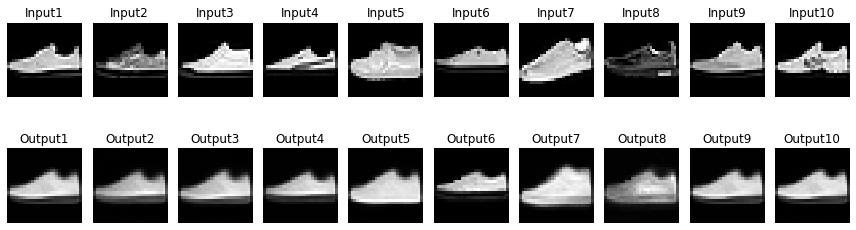

result was saved to >> result/AE_anormalyDetect_mnist_result_iter1000.jpg
Iter:2000, Loss:0.0600                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

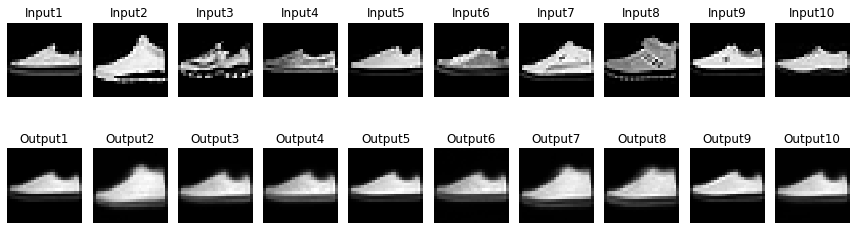

result was saved to >> result/AE_anormalyDetect_mnist_result_iter2000.jpg
Iter:3000, Loss:0.0623                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

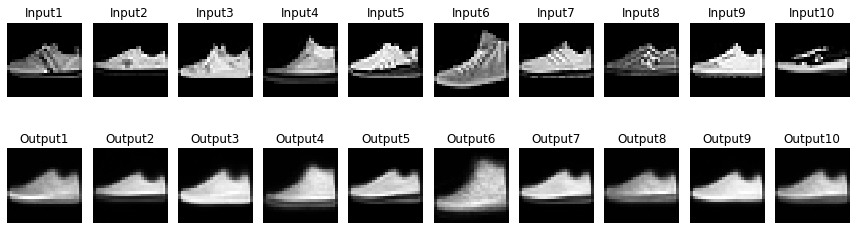

result was saved to >> result/AE_anormalyDetect_mnist_result_iter3000.jpg
Iter:4000, Loss:0.0607                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

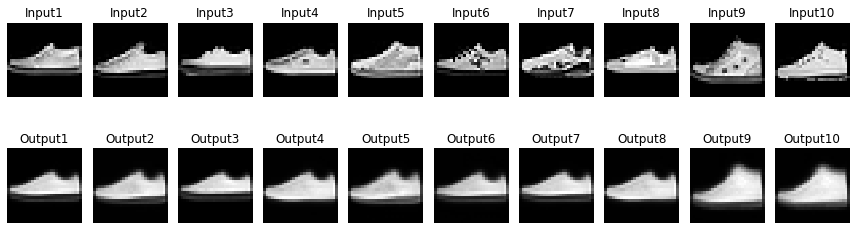

result was saved to >> result/AE_anormalyDetect_mnist_result_iter4000.jpg
Iter:5000, Loss:0.0618                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

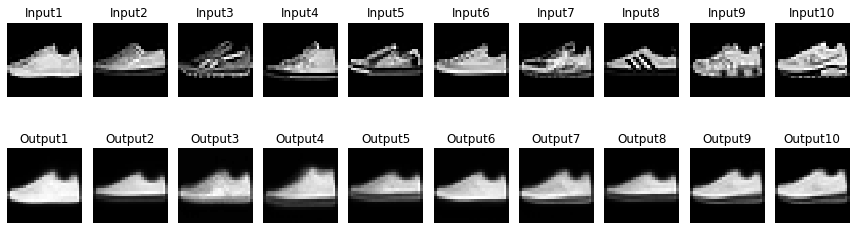

result was saved to >> result/AE_anormalyDetect_mnist_result_iter5000.jpg
final paramters were saved to >> models/AE_anormalyDetect_mnist_final.pt
loss was saved to >> result/AE_anormalyDetect_mnist_loss.txt


In [5]:
# train
def train():
    # model
    model = AE().to(cfg.DEVICE)
    
    summary(model,(cfg.INPUT_CHANNEL, cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH))
    
    opt = cfg.TRAIN.OPTIMIZER(model.parameters(), **cfg.TRAIN.LEARNING_PARAMS)
    
    #path_dict = data_load(cfg)
    #paths = path_dict['paths']
    #paths_gt = path_dict['paths_gt']

    trainset = torchvision.datasets.FashionMNIST(root=cfg.TRAIN.DATA_PATH , train=True, download=True, transform=None)
    train_Xs = trainset.data.numpy()
    train_ts = trainset.targets
    
    train_Xs = train_Xs[train_ts == cfg.ANORMALY_DETECT_TARGET_CLASS]
    
    print('training data : ', train_Xs.shape)

    # training
    mbi = 0
    train_N = len(train_Xs)
    train_ind = np.arange(train_N)
    np.random.seed(0)
    np.random.shuffle(train_ind)

    list_iter = []
    list_loss = []

    print('training start')
    progres_bar = ''
    
    for i in range(cfg.TRAIN.ITERATION):
        # get minibatch
        if mbi + cfg.TRAIN.MINIBATCH > train_N:
            mb_ind = train_ind[mbi:]
            np.random.shuffle(train_ind)
            mb_ind = np.hstack((mb_ind, train_ind[ : (cfg.TRAIN.MINIBATCH - (train_N - mbi))]))
            mbi = cfg.TRAIN.MINIBATCH - (train_N - mbi)
        else:
            mb_ind = train_ind[mbi : mbi + cfg.TRAIN.MINIBATCH]
            mbi += cfg.TRAIN.MINIBATCH

        # train
        opt.zero_grad()

        # sample X, y
        Xs = torch.tensor(preprocess(train_Xs[mb_ind], cfg, cfg.INPUT_MODE, 
                                    hf=cfg.TRAIN.DATA_HORIZONTAL_FLIP, vf=cfg.TRAIN.DATA_VERTICAL_FLIP, rot=cfg.TRAIN.DATA_ROTATION),
                          dtype=torch.float).to(cfg.DEVICE)
        #ts = torch.tensor(train_ts[mb_ind], dtype=torch.float).to(device)

        # forward
        ys = model(Xs)
        # loss
        loss = cfg.TRAIN.LOSS_FUNCTION(ys, Xs.view(cfg.TRAIN.MINIBATCH, -1))
        # update
        loss.backward()
        opt.step()

        progres_bar += '|'
        print('\r' + progres_bar, end='')

        _loss = loss.item()

        if (i + 1) % cfg.TRAIN.LEARNING_PROCESS_PROGRESS_INTERVAL == 0:
            progres_bar += str(i + 1)
            print('\r' + progres_bar, end='')

            # save process result
            if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
                list_iter.append(i + 1)
                list_loss.append(_loss)
    
        # display training state
        if (i + 1) % cfg.TRAIN.DISPLAY_ITERATION_INTERVAL == 0:
            print('\r' + ' ' * len(progres_bar), end='')
            print('\rIter:{}, Loss:{:.4f} '.format(i + 1, _loss))
            progres_bar = ''

        # save parameters
        if (cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i + 1) % cfg.TRAIN.MODEL_SAVE_INTERVAL == 0):
            save_path = cfg.TRAIN.MODEL_SAVE_PATH.format('iter{}'.format(i + 1))
            torch.save(model.state_dict(), save_path)
            print('save >> {}'.format(save_path))

        # show process result
        if (cfg.TRAIN.LEARNING_PROCESS_RESULT_SHOW != False) and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_SHOW == 0):
            result_show(
                model, Xs, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('iter' + str(i + 1)), 
                save=False, show=True, cmap=cfg.OUTPUT_CMAP)
            
        # save process result
        if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL == 0):
            result_show(
                model, Xs, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('iter' + str(i + 1)), 
                save=True, show=False, cmap=cfg.OUTPUT_CMAP)

    save_path = cfg.TRAIN.MODEL_SAVE_PATH.format('final')
    torch.save(model.state_dict(), save_path)
    print('final paramters were saved to >> {}'.format(save_path))

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        df = pd.DataFrame({'iteration' : list_iter, 'loss' : list_loss})
        df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
        print('loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))

train()

## Test

--------------------
test function
--------------------


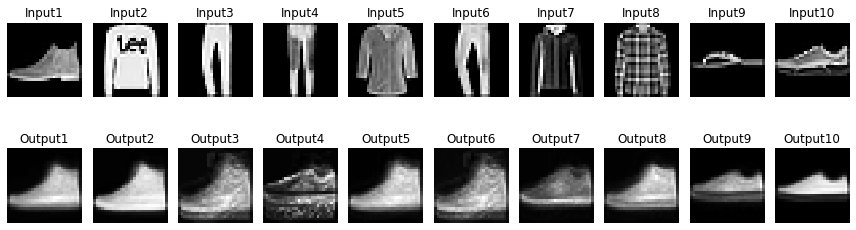

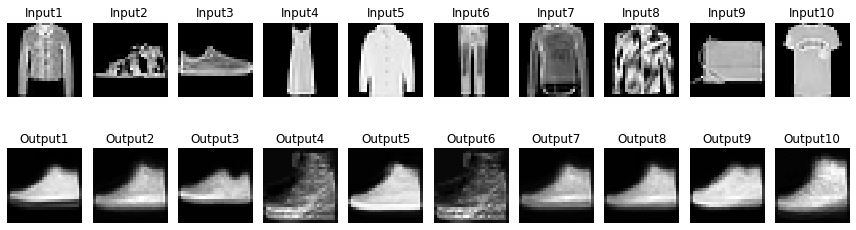

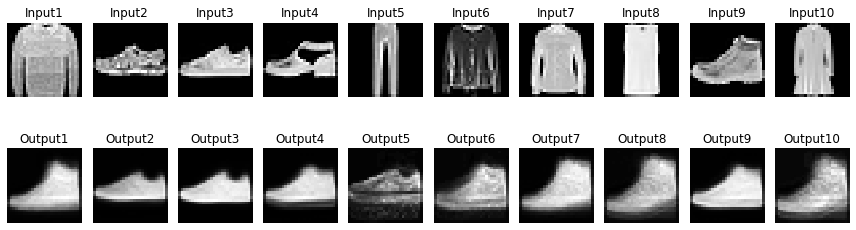

In [6]:
# test
def test():
    print('-' * 20)
    print('test function')
    print('-' * 20)
    
    model = AE().to(cfg.DEVICE)
    model.load_state_dict(torch.load(cfg.TEST.MODEL_PATH, map_location=torch.device(cfg.DEVICE)))
    model.eval()

    #path_dict = data_load(cfg, train=False, hf=False, vf=False, rot=False)
    #paths = path_dict['paths']
    #paths_gt = path_dict['paths_gt']
    
    trainset = torchvision.datasets.FashionMNIST(root=cfg.TRAIN.DATA_PATH , train=False, download=True, transform=None)
    train_Xs = trainset.data.numpy()
    train_ts = trainset.targets
    
    Test_Num = min(len(train_Xs), cfg.TEST.MAX_SAMPLES)
    
    np.random.seed(0)
    
    with torch.no_grad():
        for i in range(0, Test_Num, cfg.TEST.MINIBATCH):
            mb_ind = np.arange(i, min(i + cfg.TEST.MINIBATCH, Test_Num))
            
            # sample X, y
            Xs = torch.tensor(preprocess(train_Xs[mb_ind], cfg, cfg.INPUT_MODE, hf=False, vf=False, rot=False), dtype=torch.float).to(cfg.DEVICE)           

            result_show(model, Xs, cfg.TEST.RESULT_IMAGE_PATH.format(i + 1), 
                        save=cfg.TEST.RESULT_SAVE, show=True, cmap=cfg.OUTPUT_CMAP)

test()

## Anormaly Detection

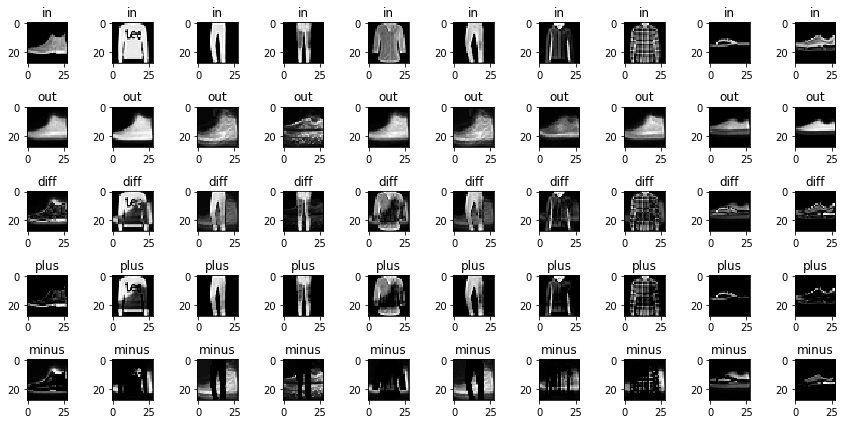

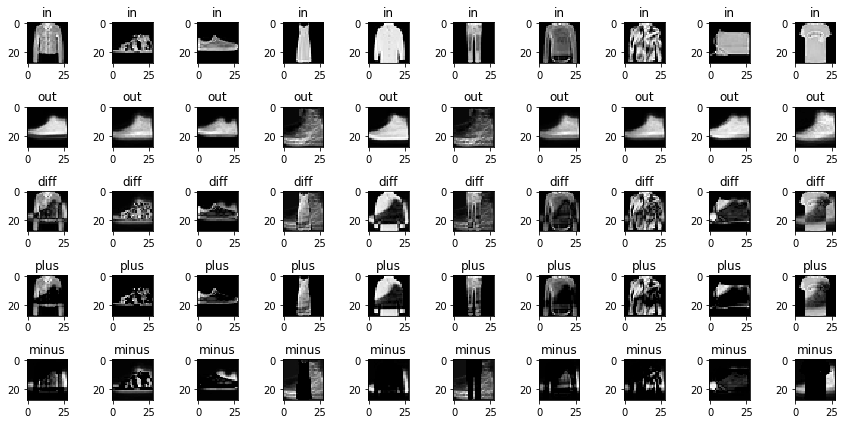

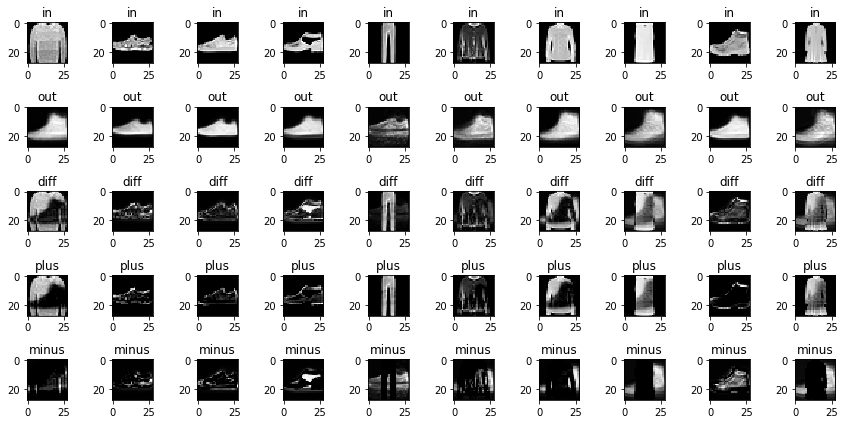

In [7]:
def anormaly_detect():
    model = AE().to(cfg.DEVICE)
    model.load_state_dict(torch.load(cfg.TEST.MODEL_PATH, map_location=torch.device(cfg.DEVICE)))
    model.eval()

    trainset = torchvision.datasets.FashionMNIST(root=cfg.TRAIN.DATA_PATH , train=False, download=True, transform=None)
    train_Xs = trainset.data.numpy()
    train_ts = trainset.targets
    
    Test_Num = min(len(train_Xs), cfg.TEST.MAX_SAMPLES)
    
    np.random.seed(0)
    
    with torch.no_grad():
        for i in range(0, Test_Num, cfg.TEST.MINIBATCH):
            mb_ind = np.arange(i, min(i + cfg.TEST.MINIBATCH, Test_Num))
            
            # sample X, y
            Xs = preprocess(train_Xs[mb_ind], cfg, cfg.INPUT_MODE, hf=False, vf=False, rot=False)
            _Xs = torch.tensor(Xs, dtype=torch.float).to(cfg.DEVICE)           

            ys = model(_Xs).detach().cpu().numpy()
            ys = ys.reshape([-1, cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH])
            
            if cfg.OUTPUT_CHANNEL == 1:
                Xs = Xs[:, 0]
                ys = ys[:, 0]
            else:
                Xs = Xs.transpose(0, 2, 3, 1)
                ys = _ys.transpose(0, 2, 3, 1)
            
            Xs = (Xs * 127.5 + 127.5).astype(np.uint8)
            ys = (ys * 127.5 + 127.5).astype(np.uint8)
            diff = np.abs(Xs.astype(int) - ys.astype(int)).astype(np.uint8)
            diff_plus = np.maximum(Xs.astype(int) - ys.astype(int), 0).astype(np.uint8)
            diff_minus = np.maximum(ys.astype(int) - Xs.astype(int), 0).astype(np.uint8)
           
            sample_num = len(mb_ind)
        
            plt.figure(figsize=(12, 6))
            for j in range(sample_num):
                plt.subplot(5, sample_num, j + 1)
                plt.imshow(Xs[j], cmap=cfg.OUTPUT_CMAP)
                plt.title('in')
                plt.subplot(5, sample_num, j + 1 + sample_num)
                plt.imshow(ys[j], cmap=cfg.OUTPUT_CMAP)
                plt.title('out')
                plt.subplot(5, sample_num, j + 1 + sample_num * 2)
                plt.imshow(diff[j], cmap=cfg.OUTPUT_CMAP)
                plt.title('diff')
                plt.subplot(5, sample_num, j + 1 + sample_num * 3)
                plt.imshow(diff_plus[j], cmap=cfg.OUTPUT_CMAP)
                plt.title('plus')
                plt.subplot(5, sample_num, j + 1 + sample_num * 4)
                plt.imshow(diff_minus[j], cmap=cfg.OUTPUT_CMAP)
                plt.title('minus')
            
            plt.tight_layout()
            plt.show()
    
anormaly_detect()

## Encoded latent map

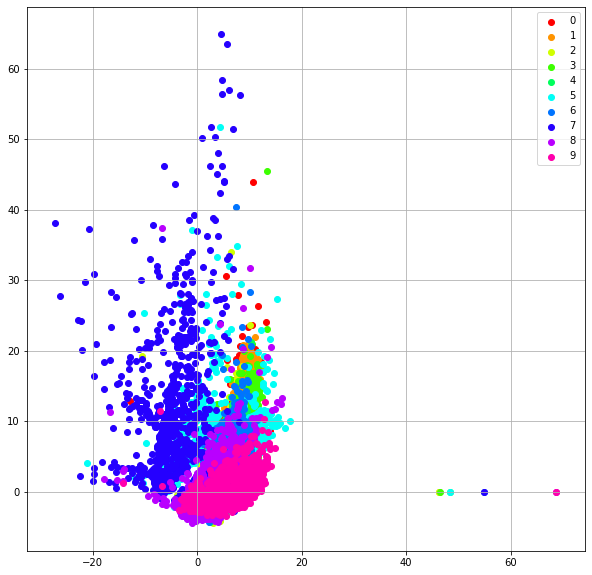

In [8]:
import matplotlib.cm

def latent_show():
    model = AE().to(cfg.DEVICE)
    model.load_state_dict(torch.load(cfg.TEST.MODEL_PATH, map_location=torch.device(cfg.DEVICE)))
    model.eval()

    plt.figure(figsize=[10, 10])
    
    colors = np.array([matplotlib.cm.hsv(i / cfg.CLASS_NUM) for i in range(cfg.CLASS_NUM)])
    
    mb = 512
    
    testset = torchvision.datasets.FashionMNIST(root=cfg.TRAIN.DATA_PATH , train=False, download=True, transform=None)
    test_Xs = testset.data.numpy()
    test_ts = testset.targets
    
    Test_Num = len(test_Xs)
    
    np.random.seed(0)
    
    with torch.no_grad():
        for class_i in range(cfg.CLASS_NUM):
            _test_Xs = test_Xs[test_ts == class_i]

            Test_Num = len(_test_Xs)
            
            z1 = np.ndarray(shape=1)
            z2 = np.ndarray(shape=1)
            
            for i in range(0, Test_Num, mb):
                mb_ind = np.arange(i, min(i + mb, Test_Num))

                # sample X, y
                Xs = torch.tensor(preprocess(_test_Xs[mb_ind], cfg, cfg.INPUT_MODE, hf=False, vf=False, rot=False), dtype=torch.float).to(cfg.DEVICE)           

                # forward
                z = model.forward_encoder(Xs).detach().cpu().numpy()
                
                z1 = np.append(z1, z[:, 0])
                z2 = np.append(z2, z[:, 1])

            plt.scatter(z1, z2, c=[colors[class_i]], label=class_i)
    
    plt.grid()
    plt.legend()
    plt.savefig('result/vae_latent_show.png')
    plt.show()
    
latent_show()